In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df= pd.read_pickle("../data/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName
TimeStamp,,,
2019-11-07 12:29:06,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00
2019-11-07 12:29:26,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00
2019-11-07 12:29:26,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00
2019-11-07 12:29:30,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00
2019-11-07 12:29:32,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00


In [3]:
Voltage_df=df.drop("CurrentCurve", axis=1)
Current_df=df.drop("VoltageCurve", axis=1)

In [4]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

In [5]:
exploded_voltage=pd.DataFrame(df.VoltageCurve.tolist(), index= df.index)

In [6]:
exploded_voltage.iloc[:15]

0      1       2       3       4       5    \
spotName   TimeStamp                                                         
60000_0_00 2019-11-07 12:29:06  132  744.0  1299.0  1663.0  1894.0  2002.0   
           2019-11-07 12:29:26  136  752.0  1308.0  1675.0  1923.0  2068.0   
           2019-11-07 12:29:26  139  757.0  1292.0  1655.0  1885.0  2042.0   
           2019-11-07 12:29:30  133  743.0  1286.0  1645.0  1887.0  2046.0   
           2019-11-07 12:29:32  137  755.0  1313.0  1683.0  1906.0  2043.0   
60118_0_00 2019-11-08 17:50:59  137  779.0  1306.0  1594.0  1717.0  1775.0   
60114_0_00 2019-11-08 17:50:59  136  753.0  1255.0  1557.0  1708.0  1758.0   
60074_0_00 2019-11-08 17:51:29   97  694.0  1228.0  1513.0  1665.0  1693.0   
60058_0_00 2019-11-08 17:51:29  136  753.0  1284.0  1593.0  1779.0  1830.0   
60060_0_00 2019-11-08 17:51:29  137  787.0  1345.0  1690.0  1842.0  1919.0   
60052_0_00 2019-11-08 17:51:29  133  748.0  1274.0  1563.0  1726.0  1815.0   
60050_0_00 2019-11-08 17:51:32  138  744.0  1254.0  1553.0  1699.0  1765.0   
60048_0_00 2019-11-08 17:51:32  139  747.0  1275.0  1598.0  1789.0  1855.0   
60046_0_00 2019-11-08 17:51:32  133  756.0  1274.0  1563.0  1697.0  1786.0   
60044_0_00 2019-11-08 17:51:32  139  777.0  1319.0  1605.0  1759.0  1803.0   

                                   6       7       8       9    ...  614  615  \
spotName   TimeStamp                                            ...             
60000_0_00 2019-11-07 12:29:06  2068.0  2110.0  2076.0  2035.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2128.0  2180.0  2180.0  2103.0  ...  NaN  NaN   
           2019-11-07 12:29:26  2099.0  2099.0  2099.0  2067.0  ...  NaN  NaN   
           2019-11-07 12:29:30  2104.0  2104.0  2129.0  2079.0  ...  NaN  NaN   
           2019-11-07 12:29:32  2147.0  2189.0  2155.0  2104.0  ...  NaN  NaN   
60118_0_00 2019-11-08 17:50:59  1789.0  1717.0  1637.0  1573.0  ...  NaN  NaN   
60114_0_00 2019-11-08 17:50:59  1779.0  1743.0  1664.0  1593.0  ...  NaN  NaN   
60074_0_00 2019-11-08 17:51:29  1707.0  1693.0  1624.0  1527.0  ...  NaN  NaN   
60058_0_00 2019-11-08 17:51:29  1786.0  1765.0  1708.0  1607.0  ...  NaN  NaN   
60060_0_00 2019-11-08 17:51:29  1950.0  1888.0  1789.0  1705.0  ...  NaN  NaN   
60052_0_00 2019-11-08 17:51:29  1815.0  1756.0  1675.0  1608.0  ...  NaN  NaN   
60050_0_00 2019-11-08 17:51:32  1794.0  1757.0  1677.0  1619.0  ...  NaN  NaN   
60048_0_00 2019-11-08 17:51:32  1869.0  1869.0  1796.0  1708.0  ...  NaN  NaN   
60046_0_00 2019-11-08 17:51:32  1786.0  1726.0  1675.0  1608.0  ...  NaN  NaN   
60044_0_00 2019-11-08 17:51:32  1825.0  1796.0  1708.0  1635.0  ...  NaN  NaN   

                                616  617  618  619  620  621  622  623  
spotName   TimeStamp                                                    
60000_0_00 2019-11-07 12:29:06  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:26  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:30  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           2019-11-07 12:29:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60118_0_00 2019-11-08 17:50:59  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60114_0_00 2019-11-08 17:50:59  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60074_0_00 2019-11-08 17:51:29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60058_0_00 2019-11-08 17:51:29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60060_0_00 2019-11-08 17:51:29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60052_0_00 2019-11-08 17:51:29  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60050_0_00 2019-11-08 17:51:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60048_0_00 2019-11-08 17:51:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60046_0_00 2019-11-08 17:51:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
60044_0_00 2019-11-08 17:51:32  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[15 rows x 624 columns]

In [7]:
exploded_voltage_T=exploded_voltage.T
exploded_voltage_T.head()

spotName           60000_0_00                                          \
TimeStamp 2019-11-07 12:29:06 2019-11-07 12:29:26 2019-11-07 12:29:26   
0                       132.0               136.0               139.0   
1                       744.0               752.0               757.0   
2                      1299.0              1308.0              1292.0   
3                      1663.0              1675.0              1655.0   
4                      1894.0              1923.0              1885.0   

spotName                                                   60118_0_00  \
TimeStamp 2019-11-07 12:29:30 2019-11-07 12:29:32 2019-11-08 17:50:59   
0                       133.0               137.0               137.0   
1                       743.0               755.0               779.0   
2                      1286.0              1313.0              1306.0   
3                      1645.0              1683.0              1594.0   
4                      1887.0              1906.0              1717.0   

spotName           60114_0_00          60074_0_00          60058_0_00  \
TimeStamp 2019-11-08 17:50:59 2019-11-08 17:51:29 2019-11-08 17:51:29   
0                       136.0                97.0               136.0   
1                       753.0               694.0               753.0   
2                      1255.0              1228.0              1284.0   
3                      1557.0              1513.0              1593.0   
4                      1708.0              1665.0              1779.0   

spotName           60060_0_00  ...          60119_0_00          60115_0_00  \
TimeStamp 2019-11-08 17:51:29  ... 2020-05-28 14:59:18 2020-05-28 14:59:25   
0                       137.0  ...               137.0               134.0   
1                       787.0  ...               769.0               764.0   
2                      1345.0  ...              1298.0              1284.0   
3                      1690.0  ...              1596.0              1576.0   
4                      1842.0  ...              1755.0              1718.0   

spotName           60113_0_00          60089_0_00          60169_0_00  \
TimeStamp 2020-05-28 14:59:25 2020-05-28 14:59:25 2020-05-28 14:59:36   
0                       146.0               132.0               146.0   
1                       777.0               779.0               799.0   
2                      1297.0              1347.0              1349.0   
3                      1583.0              1701.0              1649.0   
4                      1737.0              1923.0              1796.0   

spotName           60001_0_00          60021_0_00          60023_0_00  \
TimeStamp 2020-05-28 15:00:04 2020-05-28 15:00:04 2020-05-28 15:00:17   
0                       139.0               138.0               139.0   
1                       757.0               777.0               769.0   
2                      1292.0              1332.0              1303.0   
3                      1647.0              1675.0              1652.0   
4                      1869.0              1888.0              1853.0   

spotName           60025_0_00          60027_0_00  
TimeStamp 2020-05-28 15:00:17 2020-05-28 15:00:17  
0                       134.0               136.0  
1                       763.0               744.0  
2                      1284.0              1264.0  
3                      1602.0              1600.0  
4                      1779.0              1784.0  

[5 rows x 142192 columns]

In [8]:
#quali dati hanno la massima numerosità (624) di raccolte
#exploded_voltage[exploded_voltage[623].notna()].head()

In [9]:
#per selezionare la prima riga
exploded_voltage.iloc[0]
#oppure
exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]

C:\Users\dvd_m\AppData\Local\Temp/ipykernel_14148/3076481641.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  exploded_voltage.loc[("60000_0_00","2019-11-07 12:29:06")]


,0,1,2,3,4,5,6,7,8,9,...,614,615,616,617,618,619,620,621,622,623
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2019-11-07 12:29:06,132,744.0,1299.0,1663.0,1894.0,2002.0,2068.0,2110.0,2076.0,2035.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Anomaly Detection: Pycaret

In [18]:
#pip install pycaret==2.3.5
#pip install scipy==1.4.1

In [11]:
from pycaret.anomaly import *
from sklearn.datasets import load_breast_cancer

In [20]:

#anom = setup(data = df_train, silent = True)


In [30]:
df_train

0      1       2       3       4       5  \
spotName   TimeStamp                                                         
60000_0_00 2019-11-07 12:29:06  132  744.0  1299.0  1663.0  1894.0  2002.0   
           2019-11-07 12:29:26  136  752.0  1308.0  1675.0  1923.0  2068.0   
           2019-11-07 12:29:26  139  757.0  1292.0  1655.0  1885.0  2042.0   
           2019-11-07 12:29:30  133  743.0  1286.0  1645.0  1887.0  2046.0   
           2019-11-07 12:29:32  137  755.0  1313.0  1683.0  1906.0  2043.0   
...                             ...    ...     ...     ...     ...     ...   
60025_0_00 2019-11-12 06:32:09  134  763.0  1302.0  1634.0  1814.0  1903.0   
60027_0_00 2019-11-12 06:32:09  138  741.0  1276.0  1613.0  1811.0  1915.0   
60090_0_00 2019-11-12 06:33:17  132  756.0  1323.0  1682.0  1899.0  2041.0   
60092_0_00 2019-11-12 06:33:19  138  745.0  1282.0  1638.0  1846.0  1967.0   
60094_0_00 2019-11-12 06:33:22  139  743.0  1282.0  1635.0  1849.0  1988.0   

                                     6  
spotName   TimeStamp                    
60000_0_00 2019-11-07 12:29:06  2068.0  
           2019-11-07 12:29:26  2128.0  
           2019-11-07 12:29:26  2099.0  
           2019-11-07 12:29:30  2104.0  
           2019-11-07 12:29:32  2147.0  
...                                ...  
60025_0_00 2019-11-12 06:32:09  1966.0  
60027_0_00 2019-11-12 06:32:09  1984.0  
60090_0_00 2019-11-12 06:33:17  2098.0  
60092_0_00 2019-11-12 06:33:19  2002.0  
60094_0_00 2019-11-12 06:33:22  2035.0  

[400 rows x 7 columns]

In [44]:
df_train=exploded_voltage.iloc[: , 7:50]
df_train=df_train.iloc[:400]
df_test=exploded_voltage.iloc[: , 200:207]
df_test=df_test.iloc[:400]
df_test

200     201     202     203     204  \
spotName   TimeStamp                                                     
60000_0_00 2019-11-07 12:29:06  1282.0  1274.0  1257.0  1266.0  1274.0   
           2019-11-07 12:29:26  1632.0  1658.0  1658.0  1632.0  1658.0   
           2019-11-07 12:29:26  1647.0  1655.0  1679.0  1647.0  1638.0   
           2019-11-07 12:29:30  1628.0  1612.0  1637.0  1628.0  1612.0   
           2019-11-07 12:29:32  1683.0  1674.0  1648.0  1666.0  1674.0   
...                                ...     ...     ...     ...     ...   
60025_0_00 2019-11-12 06:32:09  1571.0  1616.0  1616.0  1589.0  1598.0   
60027_0_00 2019-11-12 06:32:09  1604.0  1596.0  1561.0  1544.0  1561.0   
60090_0_00 2019-11-12 06:33:17  1587.0  1616.0  1616.0  1587.0  1578.0   
60092_0_00 2019-11-12 06:33:19  1664.0  1698.0  1698.0  1664.0  1664.0   
60094_0_00 2019-11-12 06:33:22  1663.0  1672.0  1682.0  1663.0  1645.0   

                                   205     206  
spotName   TimeStamp                            
60000_0_00 2019-11-07 12:29:06  1249.0  1249.0  
           2019-11-07 12:29:26  1675.0  1649.0  
           2019-11-07 12:29:26  1655.0  1647.0  
           2019-11-07 12:29:30  1645.0  1637.0  
           2019-11-07 12:29:32  1657.0  1657.0  
...                                ...     ...  
60025_0_00 2019-11-12 06:32:09  1598.0  1571.0  
60027_0_00 2019-11-12 06:32:09  1552.0  1578.0  
60090_0_00 2019-11-12 06:33:17  1587.0  1578.0  
60092_0_00 2019-11-12 06:33:19  1664.0  1638.0  
60094_0_00 2019-11-12 06:33:22  1672.0  1672.0  

[400 rows x 7 columns]

In [21]:
from sklearn.ensemble import IsolationForest

In [45]:
clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(df_train)  # fit 10 trees  
clf.set_params(n_estimators=20)  # add 10 more trees  
clf.fit(df_train)  # fit the added trees  

IsolationForest(bootstrap=False, contamination='auto', max_features=1.0,
                max_samples='auto', n_estimators=20, n_jobs=None,
                random_state=None, verbose=0, warm_start=True)

In [52]:
clf = IsolationForest(max_samples=100)
clf.fit(df_train)
pred_train = clf.predict(df_train)


In [53]:
X_outliers = df_train[pred_train == -1]
X_valid = df_train[pred_train != -1]

In [54]:
print("Original Samples : ",df_train.shape[0])
print("Number of Outliers : ", X_outliers.shape[0])
print("Number of Normal Samples : ", X_valid.shape[0])

Original Samples :  400
Number of Outliers :  124
Number of Normal Samples :  276


In [61]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [66]:
def plot_outliers_with_valid_samples(X_valid, X_outliers):
    with plt.style.context(("seaborn", "ggplot")):
        plt.scatter(X_valid[:, 0], X_valid[:, 1], c="tab:green", label="Valid Samples")
        plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="tab:red", label="Outliers")
        plt.legend(loc="best")


SyntaxError: invalid syntax (Temp/ipykernel_14148/523932335.py, line 1)

In [15]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(df_train)

In [18]:
len(yhat)

400

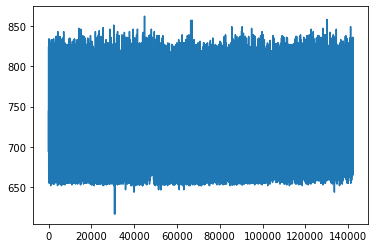

In [17]:
plt.plot(exploded_voltage[1].values)

In [45]:
dummy=[]
for i in range(0, 20):
    dummy.extend(df["CurrentCurve"][i])